In [474]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.api import acf, pacf, graphics
from statsmodels.tsa.seasonal import STL
import numpy as np
from datetime import datetime

In [475]:
sns.set_style('darkgrid')
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc('figure',figsize=(16, 6))

In [476]:
data = pd.read_csv('daily_data.csv')
data.index = pd.to_datetime(data.date)

start_dt = datetime.strptime('06/04/2018', "%d/%m/%Y")
data = data[(data.index >= start_dt)]

data['prexmas'] = data.index.week.isin([50,51]).astype(int)
data['xmas'] = data.index.week.isin([52,1]).astype(int)
data['dow'] = data.index.dayofweek
data['we'] = data.dow.isin([5,6]).astype(int)
data = data['2018-02-12':]
data = data.asfreq('d')
data.head()

,date,price,quantity,advertising,temp_av,score,comp_score,score_accum,comp_score_accum,score_ratio,views,customers,prexmas,xmas,dow,we
date,,,,,,,,,,,,,,,,
2018-04-06,2018-04-06,29.99,1.0,6.930769,10.166667,0.0,0.0,26.0,51.0,0.509804,41.0,33.0,0,0,4,0
2018-04-07,2018-04-07,29.99,2.0,6.930769,12.111111,0.0,2.0,26.0,53.0,0.490566,28.0,27.0,0,0,5,1
2018-04-08,2018-04-08,29.99,2.0,6.930769,10.000000,0.0,6.0,26.0,59.0,0.440678,30.0,24.0,0,0,6,1
2018-04-09,2018-04-09,29.99,0.0,6.930769,8.777778,0.0,0.0,26.0,59.0,0.440678,30.0,26.0,0,0,0,0
2018-04-10,2018-04-10,27.99,1.0,6.930769,10.555556,0.0,0.0,26.0,59.0,0.440678,29.0,26.0,0,0,1,0


In [477]:
"""
Lets consider a specific model for the quantity of sales:
There are three interacting components for Quantity of Sales (Q):

i) Customer Demand (D), ie daily searches for the product type.

ii) Amazon Traffic (T), rate of searches that are directed by Amazon to the product page (the mechanism behind this 
traffic rate is the ranking of the product within the search algorithm).

iii) Conversions (C), rate of traffic to product site resulting in sales.

where Q = D * Trate * C

let D = aX(d)(t), where X(d) = {c(d), temperature, xmas, we}
let T = bX(t)(t, t-1, t-2, ...), where X(t) = {c(t), advertising, score, AR(), MA()}
let C = cX(c)(t), where X(c) = {c(c), price, quality(~score)}

we assume C constant, ie conversion is constant
we assume c(t) = 0, ie no advertising or score of previous sales will result in a zero rate of conversion

q = A * ([B, w, x, we]*[C, a, s, AR, MA])
q = a * [BC, Ba, Bs, BAR, BMA, wC, wa, ws, wAR, wMA, xC, xa, xs, xAR xMA, wC, wea, wes, weAR weMA]

we test for the significance of the AR and MA processes in this model and interpret them
"""

'\nLets consider a specific model for the quantity of sales:\nThere are three interacting components for Quantity of Sales (Q):\n\ni) Customer Demand (D), ie daily searches for the product type.\n\nii) Amazon Traffic (T), rate of searches that are directed by Amazon to the product page (the mechanism behind this \ntraffic rate is the ranking of the product within the search algorithm).\n\niii) Conversions (C), rate of traffic to product site resulting in sales.\n\nwhere Q = D * Trate * C\n\nlet D = aX(d)(t), where X(d) = {c(d), temperature, xmas, we}\nlet T = bX(t)(t, t-1, t-2, ...), where X(t) = {c(t), advertising, score, AR(), MA()}\nlet C = cX(c)(t), where X(c) = {c(c), price, quality(~score)}\n\nwe assume C constant, ie conversion is constant\nwe assume c(t) = 0, ie no advertising or score of previous sales will result in a zero rate of conversion\n\nq = A * ([B, w, x, we]*[C, a, s, AR, MA])\nq = a * [BC, Ba, Bs, BAR, BMA, wC, wa, ws, wAR, wMA, xC, xa, xs, xAR xMA, wC, wea, wes, we

In [478]:
data.head()

,date,price,quantity,advertising,temp_av,score,comp_score,score_accum,comp_score_accum,score_ratio,views,customers,prexmas,xmas,dow,we
date,,,,,,,,,,,,,,,,
2018-04-06,2018-04-06,29.99,1.0,6.930769,10.166667,0.0,0.0,26.0,51.0,0.509804,41.0,33.0,0,0,4,0
2018-04-07,2018-04-07,29.99,2.0,6.930769,12.111111,0.0,2.0,26.0,53.0,0.490566,28.0,27.0,0,0,5,1
2018-04-08,2018-04-08,29.99,2.0,6.930769,10.000000,0.0,6.0,26.0,59.0,0.440678,30.0,24.0,0,0,6,1
2018-04-09,2018-04-09,29.99,0.0,6.930769,8.777778,0.0,0.0,26.0,59.0,0.440678,30.0,26.0,0,0,0,0
2018-04-10,2018-04-10,27.99,1.0,6.930769,10.555556,0.0,0.0,26.0,59.0,0.440678,29.0,26.0,0,0,1,0


In [479]:
data.tail()

,date,price,quantity,advertising,temp_av,score,comp_score,score_accum,comp_score_accum,score_ratio,views,customers,prexmas,xmas,dow,we
date,,,,,,,,,,,,,,,,
2020-02-03,2020-02-03,29.99,3.0,5.248167,9.055556,0.0,4.0,263.0,458.0,0.574236,146.0,111.0,0,0,0,0
2020-02-04,2020-02-04,29.99,12.0,5.248167,6.944444,0.0,4.0,263.0,462.0,0.569264,153.0,115.0,0,0,1,0
2020-02-05,2020-02-05,29.99,9.0,5.248167,4.833333,0.0,2.0,263.0,464.0,0.566810,138.0,103.0,0,0,2,0
2020-02-06,2020-02-06,29.99,4.0,5.248167,3.611111,0.0,0.0,263.0,464.0,0.566810,149.0,117.0,0,0,3,0
2020-02-07,2020-02-07,29.99,10.0,5.248167,5.611111,0.0,0.0,263.0,464.0,0.566810,126.0,111.0,0,0,4,0


In [482]:
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

def ols_combinations_helper(data, endog, combination):
    y = data[endog]
    x = data[combination]
#     x = sm.add_constant(x)
    model = ARIMA(
        y,
        order=(0,0,0),
        exog=data[combination]
    )
#     model = sm.OLS(y, x)
    return model.fit()

def build_interacting_arma(data, endog, exog, interacting_exog_endog, ar_lags=0, ma_lags=0, restrict=None):
    
    x_col = exog
    new_df = data.loc[:, set([endog]  + exog + interacting_exog_endog)]
    
    print('adding AR lags')
    for i in range(1, ar_lags+1):
        name = f"AR{i}"
        print(name)
        x_col.append(name)
        new_df[name] = data.loc[:,endog].shift(-i)
                
    print('build interacting AR lags')
    for ex in interacting_exog_endog:
        for i in range(1, ar_lags+1):
            name = f"{ex}_AR{i}"
            print(name)
            x_col.append(name)
            new_df[name] = np.array(new_df[f"AR{i}"]) * np.array(data[ex])
                         
    length = len(data) - max([ar_lags, ma_lags])
    if restrict:
        x_col = [x for x in x_col if x not in restrict]
        
    print(x_col)
        
    new_df = new_df.iloc[:length, :]
    results = ols_combinations_helper(new_df, endog, x_col)
    new_df['pred'] = results.predict()
    new_df['resid'] = results.resid
    
    return results, new_df

In [483]:
interacting_builder = {
    'advertising': ['advertising'],
    'score_accum': ['score_accum'],
#     'temp_adv': ['temp_av', 'advertising'],
#     'temp': ['temp_av'],
#     'temp_score': ['temp_av', 'score_accum'],
#     'xmas': ['xmas'],
#     'xmas_adv': ['xmas', 'advertising'],
#     'xmas_score': ['xmas', 'score_accum'],
#     'we': ['we'],
#     'we_adv': ['we', 'advertising'],
#     'we_score': ['we', 'score_accum'],
}

data_interacting = data.copy()
for col, names in interacting_builder.items():
    data_interacting[col] = data.loc[:, names].sum(axis=1)
    
exog = list(interacting_builder)

interacting_exog_endog = [
#     'temp_av',
#     'we',
#     'xmas'
]
 
results, results_df = build_interacting_arma(
    data_interacting,
    endog='views',
    exog=exog,
    interacting_exog_endog=interacting_exog_endog,
    ar_lags=2,
)
results.summary()

adding AR lags
AR1
AR2
build interacting AR lags
['advertising', 'score_accum', 'AR1', 'AR2']


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  views   No. Observations:                  671
Model:                          ARIMA   Log Likelihood               -2883.216
Date:                Sun, 05 Apr 2020   AIC                           5778.432
Time:                        22:50:59   BIC                           5805.485
Sample:                    04-06-2018   HQIC                          5788.910
                         - 02-05-2020                                         
Covariance Type:                  opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -6.9204      3.454     -2.004      0.045     -13.690      -0.151
advertising     1.8576      0.408      4.558      0.000       1.059       2.656
score_accum     0.0810      0.014      5.885      0.000       0.054       0.108
AR1             0.4519      0.020     22.918      0.000       0.413       0.491
AR2             0.3110      0.025     12.458      0.000       0.262       0.360
sigma2        316.0336      8.929     35.394      0.000     298.533     333.534
===================================================================================
Ljung-Box (Q):                       68.06   Jarque-Bera (JB):              1629.88
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.58   Skew:                             0.94
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

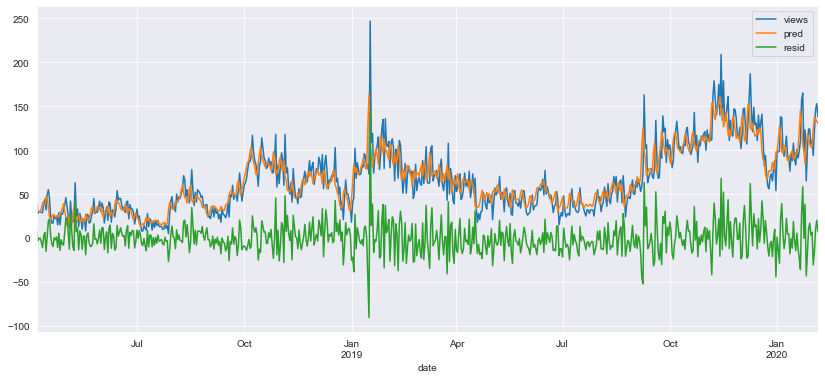

In [484]:
fig, ax = plt.subplots(1, figsize=(14,6))
results_df[['views', 'pred', 'resid']].plot(ax=ax)

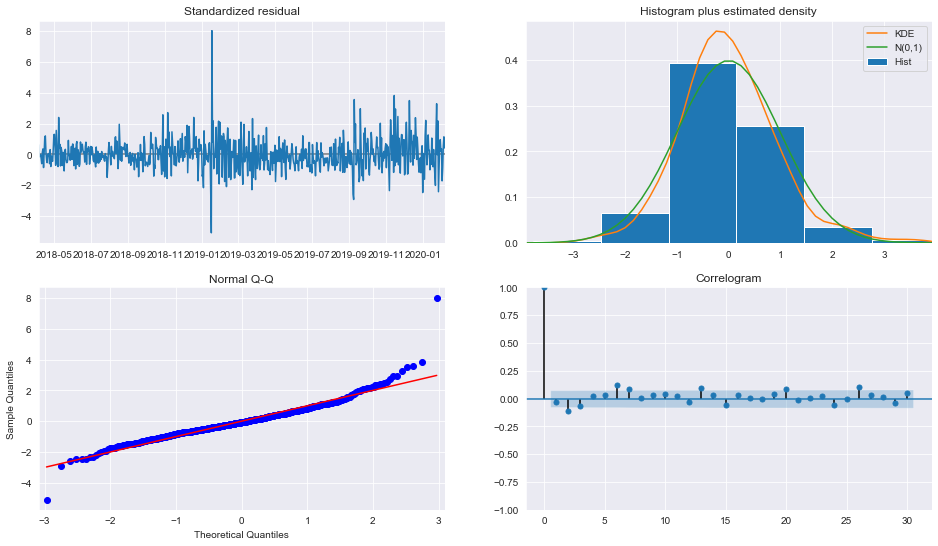

In [486]:
fig = plt.figure(figsize=(16,9))
fig = results.plot_diagnostics(fig=fig, lags=30)

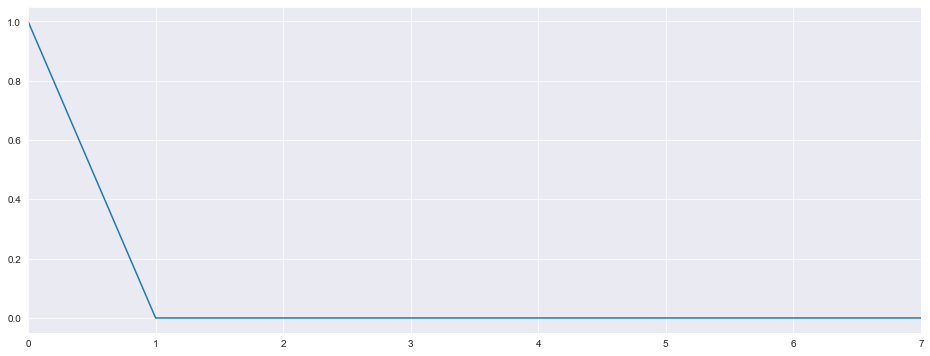

In [488]:
results.impulse_responses(steps=7).plot()

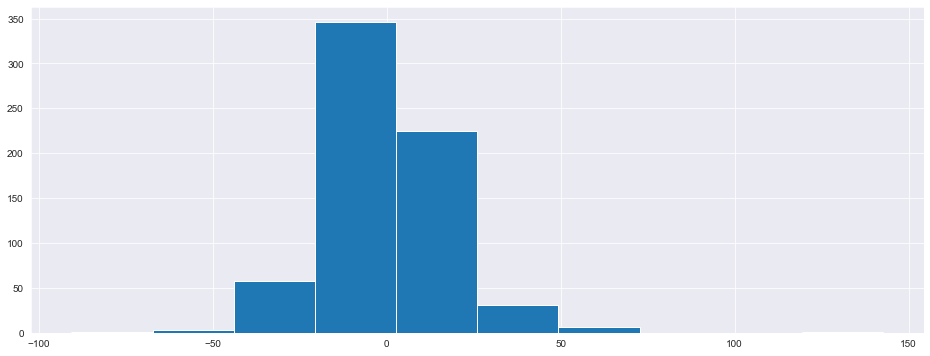

In [455]:
results_df.resid.hist()

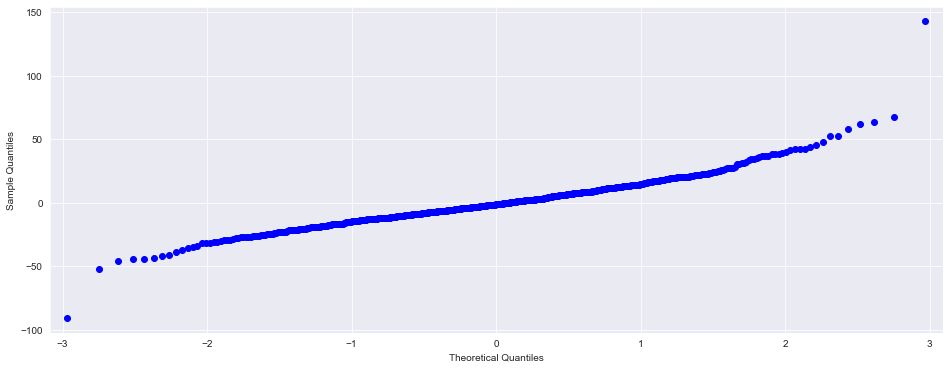

In [456]:
fig = sm.qqplot(results_df.resid)
plt.show()

In [460]:
# https://towardsdatascience.com/going-from-r-to-python-linear-regression-diagnostic-plots-144d1c4aa5a

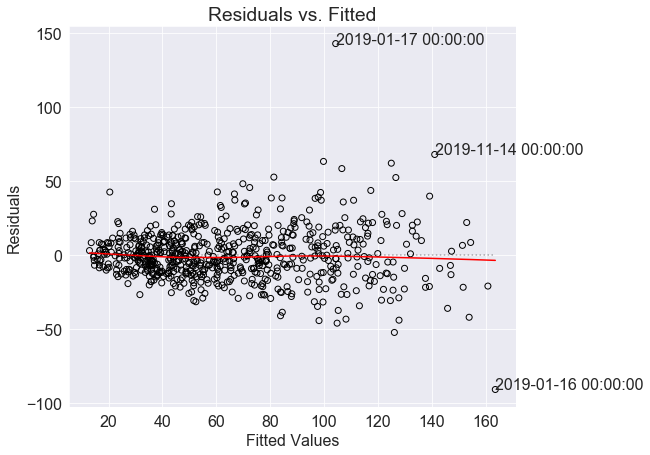

In [461]:
from statsmodels.nonparametric.smoothers_lowess import lowess
residuals = results_df.resid
fitted = results_df.pred
smoothed = lowess(residuals,fitted)
top3 = abs(residuals).sort_values(ascending = False)[:3]

plt.rcParams.update({'font.size': 16})
plt.rcParams["figure.figsize"] = (8,7)
fig, ax = plt.subplots()
ax.scatter(fitted, residuals, edgecolors = 'k', facecolors = 'none')
ax.plot(smoothed[:,0],smoothed[:,1],color = 'r')
ax.set_ylabel('Residuals')
ax.set_xlabel('Fitted Values')
ax.set_title('Residuals vs. Fitted')
ax.plot([min(fitted),max(fitted)],[0,0],color = 'k',linestyle = ':', alpha = .3)

for i in top3.index:
    ax.annotate(i,xy=(fitted[i],residuals[i]))

plt.show()

In [462]:
sorted_student_residuals = pd.Series(results.get_influence().resid_studentized_internal)
sorted_student_residuals.index = results.resid.index
sorted_student_residuals = sorted_student_residuals.sort_values(ascending = True)
df = pd.DataFrame(sorted_student_residuals)
df.columns = ['sorted_student_residuals']
df['theoretical_quantiles'] = stats.probplot(df['sorted_student_residuals'], dist = 'norm', fit = False)[0]
rankings = abs(df['sorted_student_residuals']).sort_values(ascending = False)
top3 = rankings[:3]

fig, ax = plt.subplots()
x = df['theoretical_quantiles']
y = df['sorted_student_residuals']
ax.scatter(x,y, edgecolor = 'k',facecolor = 'none')
ax.set_title('Normal Q-Q')
ax.set_ylabel('Standardized Residuals')
ax.set_xlabel('Theoretical Quantiles')
ax.plot([np.min([x,y]),np.max([x,y])],[np.min([x,y]),np.max([x,y])], color = 'r', ls = '--')
for val in top3.index:
    ax.annotate(val,xy=(df['theoretical_quantiles'].loc[val],df['sorted_student_residuals'].loc[val]))
plt.show()

NameError: name 'stats' is not defined

In [443]:
interacting_builder = {
    'advertising': ['advertising'],
    'score_accum': ['score_accum'],
    'temp_adv': ['temp_av', 'advertising'],
    'temp': ['temp_av'],
    'temp_score': ['temp_av', 'score_accum'],
    'xmas': ['xmas'],
    'xmas_adv': ['xmas', 'advertising'],
    'xmas_score': ['xmas', 'score_accum'],
    'we': ['we'],
    'we_adv': ['we', 'advertising'],
    'we_score': ['we', 'score_accum'],
}

data_interacting = data.copy()
for col, names in interacting_builder.items():
    data_interacting[col] = data.loc[:, names].sum(axis=1)
    
exog = list(interacting_builder)

interacting_exog_endog = [
    'temp_av',
    'we',
    'xmas'
]
 
results, results_df = build_interacting_arma(
    data_interacting,
    endog='views',
    exog=exog,
    interacting_exog_endog=interacting_exog_endog,
    ar_lags=1,
)
results.summary()

adding AR lags
AR1
build interacting AR lags
temp_av_AR1
we_AR1
xmas_AR1
['advertising', 'score_accum', 'temp_adv', 'temp', 'temp_score', 'xmas', 'xmas_adv', 'xmas_score', 'we', 'we_adv', 'we_score', 'AR1', 'temp_av_AR1', 'we_AR1', 'xmas_AR1']


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  views   R-squared:                       0.766
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     240.5
Date:                Sun, 05 Apr 2020   Prob (F-statistic):          5.27e-202
Time:                        22:12:50   Log-Likelihood:                -2898.7
No. Observations:                 672   AIC:                             5817.
Df Residuals:                     662   BIC:                             5862.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          11.4655      5.926      1.935      0.053      -0.171      23.102
advertising     2.4990      1.635      1.529      0.127      -0.711       5.709
score_accum     1.9748      1.633      1.210      0.227      -1.231       5.180
temp_adv        0.6829      0.540      1.263      0.207      -0.378       1.744
temp           -1.8161      1.111     -1.635      0.103      -3.998       0.365
temp_score      0.1587      0.533      0.298      0.766      -0.888       1.205
xmas           -3.5729      4.114     -0.868      0.385     -11.651       4.505
xmas_adv       -1.0740      2.565     -0.419      0.676      -6.110       3.962
xmas_score     -1.5982      2.559     -0.624      0.533      -6.624       3.428
we             -2.3918      1.743     -1.372      0.171      -5.815       1.032
we_adv          0.1072      1.020      0.105      0.916      -1.896       2.110
we_score       -0.4170      1.019     -0.409      0.682      -2.418       1.584
AR1             0.5956      0.051     11.613      0.000       0.495       0.696
temp_av_AR1     0.0002      0.004      0.050      0.960      -0.008       0.008
we_AR1         -0.0403      0.042     -0.956      0.339      -0.123       0.043
xmas_AR1       -0.0491      0.119     -0.413      0.680      -0.283       0.185
==============================================================================
Omnibus:                      180.891   Durbin-Watson:                   2.363
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1967.326
Skew:                           0.869   Prob(JB):                         0.00
Kurtosis:                      11.200   Cond. No.                     1.07e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.13e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

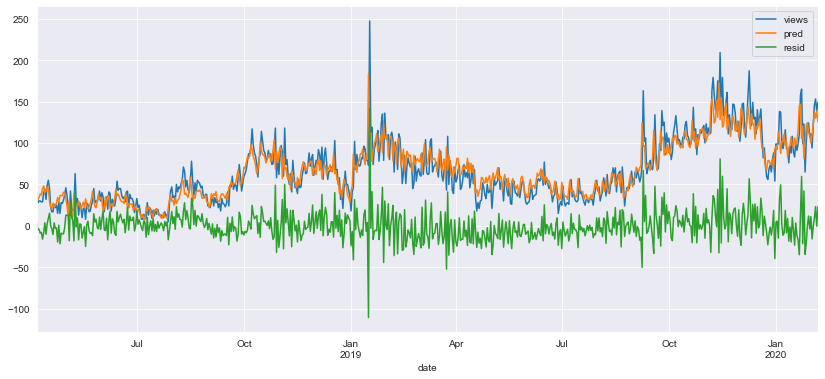

In [444]:
fig, ax = plt.subplots(1, figsize=(14,6))
results_df[['views', 'pred', 'resid']].plot(ax=ax)

In [ ]:
# ^ high confidence that AR component is +ve suggesting other interacting coefficients are 0



In [ ]:
interacting_builder = {
    'advertising': ['advertising'],
    'score_accum': ['score_accum'],
    'temp_adv': ['temp_av', 'advertising'],
    'temp': ['temp_av'],
    'temp_score': ['temp_av', 'score_accum'],
    'xmas': ['xmas'],
    'xmas_adv': ['xmas', 'advertising'],
    'xmas_score': ['xmas', 'score_accum'],
    'we': ['we'],
    'we_adv': ['we', 'advertising'],
    'we_score': ['we', 'score_accum'],
}

data_interacting = data.copy()
for col, names in interacting_builder.items():
    data_interacting[col] = data.loc[:, names].sum(axis=1)
    
exog = list(interacting_builder)

interacting_exog_endog = [
    'temp_av',
    'we',
    'xmas'
]
 
results, results_df = build_interacting_arma(
    data_interacting,
    endog='views',
    exog=exog,
    interacting_exog_endog=interacting_exog_endog,
    ar_lags=1,
)
results.summary()

In [54]:
data_interacting.head()

,quantity,advertising,score_accum,temp_av,xmas,we,temp_adv,temp_score,xmas_adv,xmas_score,we_adv,we_score,AR1,AR2,temp_av_AR1,temp_av_AR2,xmas_AR1,xmas_AR2,we_AR1,we_AR2
date,,,,,,,,,,,,,,,,,,,,
2018-02-12,2.0,0.040417,0.0,2.944444,0,0,2.984861,2.944444,0.040417,0.0,0.040417,0.0,2.0,0.0,5.888889,0.000000,0.0,0.0,0.0,0.0
2018-02-13,2.0,0.040417,4.0,4.166667,0,0,4.207083,8.166667,0.040417,4.0,0.040417,4.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
2018-02-14,0.0,0.040417,6.0,3.333333,0,0,3.373750,9.333333,0.040417,6.0,0.040417,6.0,0.0,1.0,0.000000,3.333333,0.0,0.0,0.0,0.0
2018-02-15,0.0,0.040417,8.0,7.277778,0,0,7.318194,15.277778,0.040417,8.0,0.040417,8.0,1.0,2.0,7.277778,14.555556,0.0,0.0,0.0,0.0
2018-02-16,1.0,0.040417,10.0,4.666667,0,0,4.707083,14.666667,0.040417,10.0,0.040417,10.0,2.0,0.0,9.333333,0.000000,0.0,0.0,0.0,0.0


In [55]:
data_interacting.tail()

,quantity,advertising,score_accum,temp_av,xmas,we,temp_adv,temp_score,xmas_adv,xmas_score,we_adv,we_score,AR1,AR2,temp_av_AR1,temp_av_AR2,xmas_AR1,xmas_AR2,we_AR1,we_AR2
date,,,,,,,,,,,,,,,,,,,,
2020-02-03,3.0,5.248167,263.0,9.055556,0,0,14.303722,272.055556,5.248167,263.0,5.248167,263.0,12.0,9.0,108.666667,81.500000,0.0,0.0,0.0,0.0
2020-02-04,12.0,5.248167,263.0,6.944444,0,0,12.192611,269.944444,5.248167,263.0,5.248167,263.0,9.0,4.0,62.500000,27.777778,0.0,0.0,0.0,0.0
2020-02-05,9.0,5.248167,263.0,4.833333,0,0,10.081500,267.833333,5.248167,263.0,5.248167,263.0,4.0,10.0,19.333333,48.333333,0.0,0.0,0.0,0.0
2020-02-06,4.0,5.248167,263.0,3.611111,0,0,8.859278,266.611111,5.248167,263.0,5.248167,263.0,10.0,NaN,36.111111,NaN,0.0,NaN,0.0,NaN
2020-02-07,10.0,5.248167,263.0,5.611111,0,0,10.859278,268.611111,5.248167,263.0,5.248167,263.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
df = pd.DataFrame({1:[1,2,3], 2:[1,2,3], 3:[1,2,3]}).set_index(1)

In [60]:
df[:2]

,2,3
1,,
1,1,1
2,2,2
